### <a name='a0'></a> Import bibliotek

In [ ]:
# Update biblioteki tensorflow do najnowszej wersji
!pip install -q tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil # Biblioteka wykorzystywana do kopiowania i usuwania plików
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report # Import macierzy konfuzji i raportu klasyfikacji

from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Klasa wykorzystywana do Agumentacji danych
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import AveragePooling2D


np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych

In [ ]:
#!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
#!unzip -q flying-vehicles.zip

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip  'drive/MyDrive/INZYNIERKA/DATASET.zip'

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: DATASET/FACE_MASK/NO_MASK/5557.png  
 extracting: DATASET/FACE_MASK/NO_MASK/5559.png  
  inflating: DATASET/FACE_MASK/NO_MASK/556.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5560.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5561.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5562.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5563.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5564.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5565.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5566.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5567.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5568.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5569.png  
  inflating: DATASET/FACE_MASK/NO_MASK/557.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5570.png  
 extracting: DATASET/FACE_MASK/NO_MASK/5571.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5572.png  
  inflating: DATASET/FACE_MASK/NO_MASK/5573.png  
  inflating: DATASET/FACE_MASK/NO_MAS

### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [ ]:
!rm -rf ./images #usuwanie folderu images o danej nazwie, pozwala to wykonać notebook kilka razy

In [ ]:
base_dir = './DATASET/FACE_MASK' # definicja katalogu bazowego

#Sprawdzenie ilości dostępnych zdjęć dla danej klasy - incorrect_mask, mask, no_mask
number_of_files = {} # słownik z nazwą klasy i liczbą zdjęć - klucz = nazwa klasy, wartość=ilość zdjęć w danym katalogu
classes = ['INCORRECT_MASK', 'MASK', 'NO_MASK']

# os.listdir - wylistowanie plików z danej lokalizacji
# os.path.join - połaczenie ścieżki katalogu bazowego z nazwą podkatalogu 
# Przeszukanie wszytskich podkatalogów katalogu bazowego - ./dataset-TEST/face_mask i zliczająć ilosć zdjęć w każdym z nich 
for dir in classes:
    number_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

number_of_files.items()

dict_items([('INCORRECT_MASK', 10838), ('MASK', 45648), ('NO_MASK', 10284)])

In [ ]:
data_dir = './images' # tworzymy kataloga na dane

if not os.path.exists(data_dir): # tworzy katalog - images jeśli nie istnieje 
    os.mkdir(data_dir)

# Podział danych na trzy zbiory - treningowy, walidacyjny i testowy
train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego (ścieżka ./images/train )
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego (ścieżka ./images/valid )
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego (ścieżka ./images/test )

# Zbiór treningowy
train_incorrect_mask_dir = os.path.join(train_dir, 'INCORRECT_MASK') # katalog ze zdjęciami INCORRECT_MASK (ścieżka ./images/train/INCORRECT_MASK )
train_mask_dir = os.path.join(train_dir, 'MASK') # katalog ze zdjęciami MASK (ścieżka ./images/train/MASK )
train_no_mask_dir = os.path.join(train_dir, 'NO_MASK') # katalog ze zdjęciami NO_MASK (ścieżka ./images/train/NO_MASK )

# Zbiór walidacyjny
valid_incorrect_mask_dir = os.path.join(valid_dir, 'INCORRECT_MASK')
valid_mask_dir = os.path.join(valid_dir, 'MASK')
valid_no_mask_dir = os.path.join(valid_dir, 'NO_MASK')

# Zbiór testowy 
test_incorrect_mask_dir = os.path.join(test_dir, 'INCORRECT_MASK')
test_mask_dir = os.path.join(test_dir, 'MASK')
test_no_mask_dir = os.path.join(test_dir, 'NO_MASK')

# Tworzymy katalogi train, valid i test jęzli nie istnieją
for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

# Tworzymy pozostałe podkatalogi katalogi jeśli nie istnieją
dirs = [train_incorrect_mask_dir, train_mask_dir, train_no_mask_dir,
        valid_incorrect_mask_dir, valid_mask_dir, valid_no_mask_dir,
        test_incorrect_mask_dir, test_mask_dir, test_no_mask_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)        

In [ ]:
# Wylistowujemy katalogi z dataset-TEST
incorrect_mask_file_names = os.listdir(os.path.join(base_dir, 'INCORRECT_MASK'))
mask_file_names = os.listdir(os.path.join(base_dir, 'MASK'))
no_mask_file_names = os.listdir(os.path.join(base_dir, 'NO_MASK'))

# Wybieramy jedynie pliki z rozszerzeniem .jpg, .png, .jpeg 
incorrect_mask_file_names = [file_name for file_name in incorrect_mask_file_names if file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
mask_file_names = [file_name for file_name in mask_file_names if file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
no_mask_file_names = [file_name for file_name in no_mask_file_names if file_name.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [ ]:
# Określamy rozmiar danych do podziału
size = min(len(incorrect_mask_file_names), len(mask_file_names), len(no_mask_file_names))

# Określenie wielkości zbioru treningowego, testowego i walidacyjnego
train_size = int(np.floor(0.7 * size)) # 70% -> np.floor - zaokrąglanie w dół
valid_size = int(np.floor(0.2 * size)) # 20%
test_size = size - train_size - valid_size # 10%

# Indeksy ułatwiające podział danych na zbiory
train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [ ]:
# Kopiujemy zdjęcia do poszczególnych katalogów (train, valid, test) z katalogu bazowego 

# Zbiór danych - incorrect_mask
for i, file_name in enumerate(incorrect_mask_file_names): # Funkacja enumerate - zwraca indeks i nazwę pliku
    if i <= train_idx: # Zbiór treningowy
        src = os.path.join(base_dir, 'INCORRECT_MASK', file_name)
        dst = os.path.join(train_incorrect_mask_dir, file_name)
        shutil.copyfile(src, dst) # Kopiowanie zdjęć (src->dst)
    elif train_idx < i <= valid_idx: # Zbiór testowy
        src = os.path.join(base_dir, 'INCORRECT_MASK', file_name)
        dst = os.path.join(valid_incorrect_mask_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx: # Zbiór walidacyjny
        src = os.path.join(base_dir, 'INCORRECT_MASK', file_name)
        dst = os.path.join(test_incorrect_mask_dir, file_name)
        shutil.copyfile(src, dst)

# Zbiór danych - mask
for i, file_name in enumerate(mask_file_names):
    if i <= train_idx:
        src = os.path.join(base_dir, 'MASK', file_name)
        dst = os.path.join(train_mask_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'MASK', file_name)
        dst = os.path.join(valid_mask_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'MASK', file_name)
        dst = os.path.join(test_mask_dir, file_name)
        shutil.copyfile(src, dst) 

# Zbiór danych - no_mask
for i, file_name in enumerate(no_mask_file_names):
    if i <= train_idx:
        src = os.path.join(base_dir, 'NO_MASK', file_name)
        dst = os.path.join(train_no_mask_dir, file_name)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'NO_MASK', file_name)
        dst = os.path.join(valid_no_mask_dir, file_name)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'NO_MASK', file_name)
        dst = os.path.join(test_no_mask_dir, file_name)
        shutil.copyfile(src, dst)        

# Sprawdzenie ilości zdjęć w danym zbiorze
print('incorrect mask - zbiór treningowy', len(os.listdir(train_incorrect_mask_dir)))
print('incorrect mask - zbiór walidacyjny', len(os.listdir(valid_incorrect_mask_dir)))
print('incorrect mask - zbiór testowy', len(os.listdir(test_incorrect_mask_dir)))

print('mask - zbiór treningowy', len(os.listdir(train_mask_dir)))
print('mask - zbiór walidacyjny', len(os.listdir(valid_mask_dir)))
print('mask - zbiór testowy', len(os.listdir(test_mask_dir))) 

print('no mask - zbiór treningowy', len(os.listdir(train_no_mask_dir)))
print('no mask - zbiór walidacyjny', len(os.listdir(valid_no_mask_dir)))
print('no mask - zbiór testowy', len(os.listdir(test_no_mask_dir))) 

incorrect mask - zbiór treningowy 7199
incorrect mask - zbiór walidacyjny 2056
incorrect mask - zbiór testowy 1029
mask - zbiór treningowy 7199
mask - zbiór walidacyjny 2056
mask - zbiór testowy 1029
no mask - zbiór treningowy 7199
no mask - zbiór walidacyjny 2056
no mask - zbiór testowy 1029


### <a name='a3'></a> Eksplorcja danych

(-0.5, 1023.5, 1023.5, -0.5)

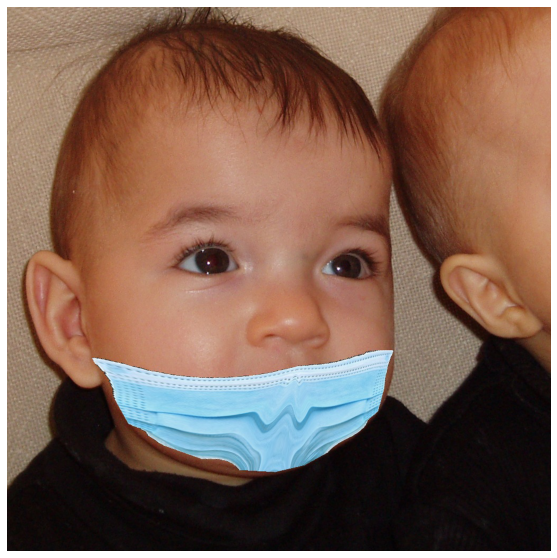

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia z ze zbioru treningowego - INCORRECT_MASK:

idx = 347 #@param {type:'slider', min:0, max:7199}
names_mapping = dict(enumerate(incorrect_mask_file_names))
img_path = os.path.join(train_incorrect_mask_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 523.5, 521.5, -0.5)

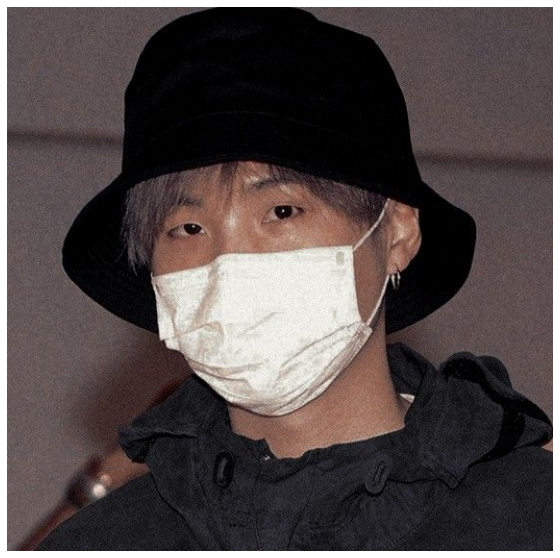

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia z ze zbioru treningowego - MASK:

idx = 693 #@param {type:'slider', min:0, max:7199}
names_mapping = dict(enumerate(mask_file_names))
img_path = os.path.join(train_mask_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 121.5, 121.5, -0.5)

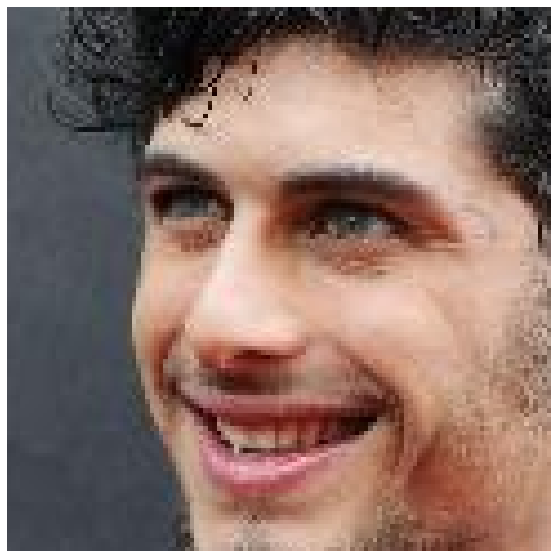

In [ ]:
#@title Wybierz indeks przykładowego zdjęcia z ze zbioru treningowego - NO_MASK:

idx = 347 #@param {type:'slider', min:0, max:7199}
names_mapping = dict(enumerate(no_mask_file_names))
img_path = os.path.join(train_no_mask_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych

In [ ]:
# Augmentacja danych - dobór parametrów
train_datagen = ImageDataGenerator(
    rotation_range=15,      # zakres losowego maksymalny obrotu zdjęcia o określony kąt
    rescale=1./255.,
    width_shift_range=0.1,  # poziome przekształcenia obrazu (przesunięcie zdjecia w lewo lub prawo)
    height_shift_range=0.1, # pionowe przekształcenia obrazu (przesuwanie w góre lub w dół)
    shear_range=0.1,        # zakres losowego przycianania obrazu
    zoom_range=0.1,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # odbicie lustrzane obrazka w płaszczyźnie pionowej
    vertical_flip = False,    # odbicie lustrzane obrazka w płaszczyźnie poziomej (obrazek dogórynogami)
    fill_mode='nearest',     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
    brightness_range = [0.4, 1.0] # jasność zdjęcia
)

# Przeskalowujemy wszystkie obrazy o współczynnik 1/255 - standaryzujemy dane
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,   # flow_from_directory - załadaowanie zdjęć bezpośrednio z katalogu - ./images/train - Keras na tej podstawie sam dobiera ilosć klas
                                                   target_size=(150, 150),  # docelowy rozmiar zdjęcia -  standaryzacja
                                                   batch_size=32, # rozmiar wsadu
                                                   class_mode='categorical') # 'categorical' - klasyfikacja wieloklasowa

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 21597 images belonging to 3 classes.
Found 6168 images belonging to 3 classes.


In [ ]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    file_names = [os.path.join(directory, file_name) for file_name in os.listdir(directory)]
    img_path = file_names[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False) # Wyświetlenie kratek na wykresie
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

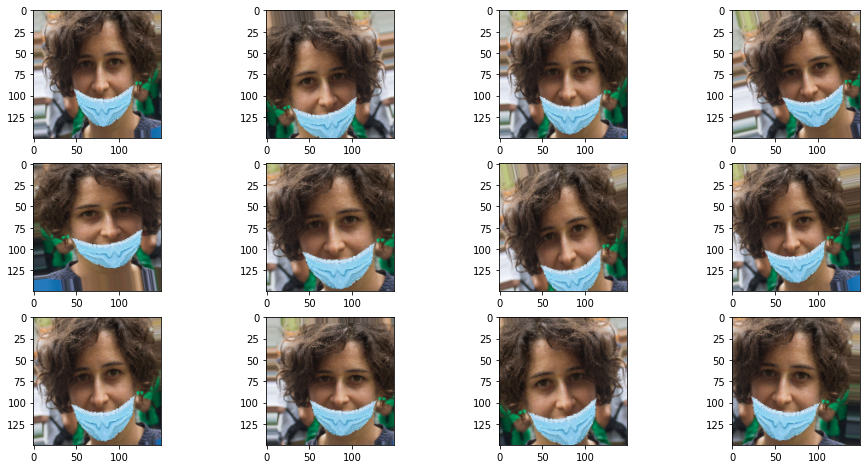

In [ ]:
#@title Zbiór treningowy - incorrect_mask:
idx = 646 #@param {type:'slider', min:0, max:7199}            
display_augmented_images(train_incorrect_mask_dir, idx)

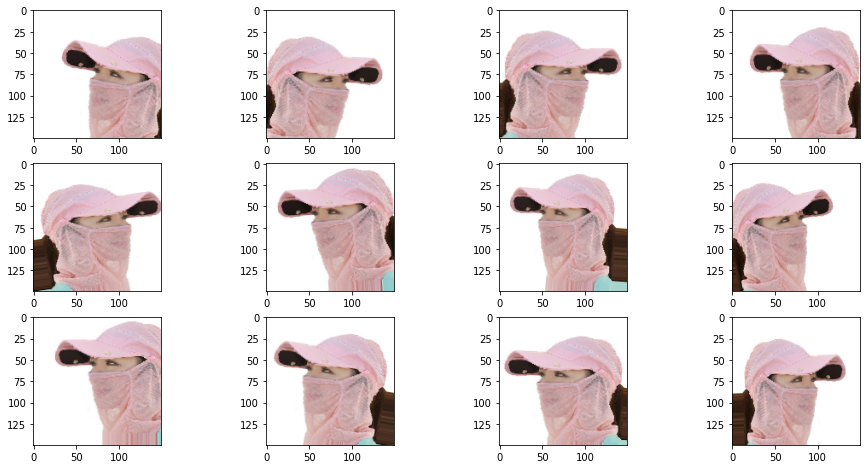

In [ ]:
#@title Zbiór treningowy - mask:
idx = 199 #@param {type:'slider', min:0, max:7199}
display_augmented_images(train_mask_dir, idx)

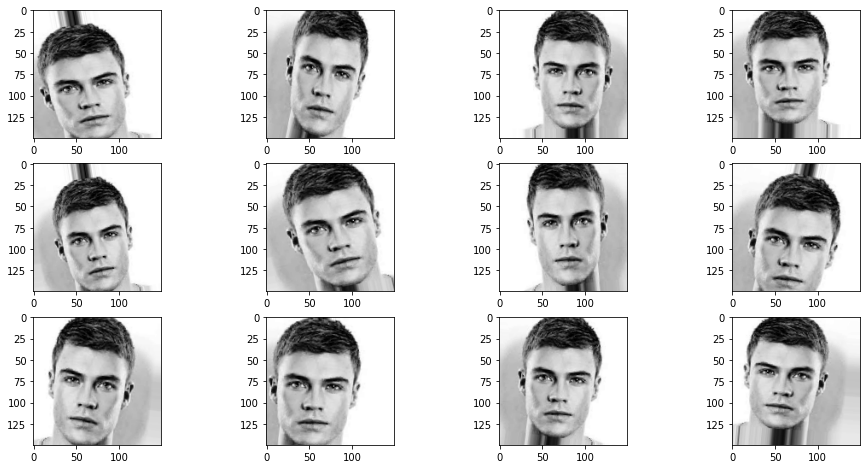

In [ ]:
#@title Zbiór treningowy bez założonej maski:
idx = 567 #@param {type:'slider', min:0, max:7199}
display_augmented_images(train_no_mask_dir, idx)

### <a name='a5'></a> Budowa modelu

In [ ]:
batch_size = 32 # Liczba obrazków wykorzystanych do trenowania sieci podczas jednego przejścia
steps_per_epoch = train_size // batch_size # ilość potrzebnych przejść przez zbiór treningowy
validation_steps = valid_size // batch_size # ilość potrzebnych przejść przez zbiór walidacyjny

### <a name='a7'></a> Własny model

In [ ]:
model = Sequential()

model.add(layers.Conv2D(filters=32, padding = 'same', kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, padding = 'same', kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, padding = 'same', kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, padding = 'same', kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_12 (Batc (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 128)      

In [ ]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

# Trenujemy dane dostarczane do generatora - augmentacja danych, rozszerzamy dane i je dodajemy do modelu (fizycznie ich nie mamy w katalogu)
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

Epoch 1/30
23/23 [==============================] - 83s 4s/step - loss: 3.7813 - accuracy: 0.7582 - val_loss: 8.3833 - val_accuracy: 0.4740
Epoch 2/30
23/23 [==============================] - 79s 3s/step - loss: 3.9046 - accuracy: 0.7524 - val_loss: 4.9435 - val_accuracy: 0.6823
Epoch 3/30
23/23 [==============================] - 81s 4s/step - loss: 3.4413 - accuracy: 0.7704 - val_loss: 6.9352 - val_accuracy: 0.5521
Epoch 4/30
23/23 [==============================] - 83s 4s/step - loss: 3.4255 - accuracy: 0.7799 - val_loss: 5.6643 - val_accuracy: 0.6198
Epoch 5/30
23/23 [==============================] - 81s 4s/step - loss: 3.5955 - accuracy: 0.7649 - val_loss: 5.1362 - val_accuracy: 0.6771
Epoch 6/30
23/23 [==============================] - 79s 3s/step - loss: 4.1879 - accuracy: 0.7304 - val_loss: 4.1057 - val_accuracy: 0.7344
Epoch 7/30
23/23 [==============================] - 83s 4s/step - loss: 3.8304 - accuracy: 0.7554 - val_loss: 3.2040 - val_accuracy: 0.7917
Epoch 8/30
23/23 [==

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_WLASNY_MODEL.h5")

### <a name='a7'></a> Transfer learning - model MobileNet 

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet

conv_base_MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_MobileNet.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_MobileNet)

17235968/17225924 [==============================] - 0s 0us/step
layer_name: input_1       trainable: True
layer_name: conv1         trainable: True
layer_name: conv1_bn      trainable: True
layer_name: conv1_relu    trainable: True
layer_name: conv_dw_1     trainable: True
layer_name: conv_dw_1_bn  trainable: True
layer_name: conv_dw_1_relu trainable: True
layer_name: conv_pw_1     trainable: True
layer_name: conv_pw_1_bn  trainable: True
layer_name: conv_pw_1_relu trainable: True
layer_name: conv_pad_2    trainable: True
layer_name: conv_dw_2     trainable: True
layer_name: conv_dw_2_bn  trainable: True
layer_name: conv_dw_2_relu trainable: True
layer_name: conv_pw_2     trainable: True
layer_name: conv_pw_2_bn  trainable: True
layer_name: conv_pw_2_relu trainable: True
layer_name: conv_dw_3     trainable: True
layer_name: conv_dw_3_bn  trainable: True
layer_name: conv_dw_3_relu trainable: True
layer_name: conv_pw_3     trainable: True
layer_name: conv_pw_3_bn  trainable: True
layer_

In [ ]:
# Douczenie ostatnich warstw sieci do naszych danych 
set_trainable = False
for layer in conv_base_MobileNet.layers:
    if layer.name == 'conv_dw_13':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print_layers(conv_base_MobileNet)

layer_name: input_1       trainable: False
layer_name: conv1         trainable: False
layer_name: conv1_bn      trainable: False
layer_name: conv1_relu    trainable: False
layer_name: conv_dw_1     trainable: False
layer_name: conv_dw_1_bn  trainable: False
layer_name: conv_dw_1_relu trainable: False
layer_name: conv_pw_1     trainable: False
layer_name: conv_pw_1_bn  trainable: False
layer_name: conv_pw_1_relu trainable: False
layer_name: conv_pad_2    trainable: False
layer_name: conv_dw_2     trainable: False
layer_name: conv_dw_2_bn  trainable: False
layer_name: conv_dw_2_relu trainable: False
layer_name: conv_pw_2     trainable: False
layer_name: conv_pw_2_bn  trainable: False
layer_name: conv_pw_2_relu trainable: False
layer_name: conv_dw_3     trainable: False
layer_name: conv_dw_3_bn  trainable: False
layer_name: conv_dw_3_relu trainable: False
layer_name: conv_pw_3     trainable: False
layer_name: conv_pw_3_bn  trainable: False
layer_name: conv_pw_3_relu trainable: False
layer

In [ ]:
model = Sequential()
model.add(conv_base_MobileNet) # architektura sieci modelu VGG16 z włączonymi 4 warstwami do trenowania
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers. Dropout(0.5))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16384)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2097280   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 5,326,531
Trainable params: 3,159,555
Non-trainable params: 2,166,976
____________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
133/224 [================>.............] - ETA: 1:27 - loss: 1.0223 - accuracy: 0.6941

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_MobilNet.h5")

### <a name='a7'></a> Transfer learning - model MobileNetV2

In [ ]:
from keras.applications.mobilenet_v2 import MobileNetV2

conv_base_MobileNet = MobileNet(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_MobileNet.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_MobileNet)

In [ ]:
# Douczenie ostatnich warstw sieci do naszych danych 
set_trainable = False
for layer in conv_base_MobileNet.layers:
    if layer.name == 'conv_dw_13':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print_layers(conv_base_MobileNet)

In [ ]:
model = Sequential()
model.add(conv_base_MobileNet) # architektura sieci modelu VGG16 z włączonymi 4 warstwami do trenowania
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers. Dropout(0.5))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_MobilNetV2.model")

### <a name='a7'></a> Transfer learning - model VGG16 

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

conv_base_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_VGG16.trainable = True # Ustawienie wszytskich warstw na trenowalne 

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_VGG16)

58900480/58889256 [==============================] - 0s 0us/step
layer_name: input_3       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
conv_base_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Douczenie ostatnich warstw sieci do naszych danych 
set_trainable = False
for layer in conv_base_VGG16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print_layers(conv_base_VGG16)

In [ ]:
model = Sequential()
model.add(conv_base_VGG16) # architektura sieci modelu VGG16 z włączonymi 4 warstwami do trenowania
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 9,177,603
Non-trainable params: 7,635,264
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
23/23 [==============================] - 12s 481ms/step - loss: 0.8500 - accuracy: 0.6726 - val_loss: 0.5317 - val_accuracy: 0.8385
Epoch 2/30
23/23 [==============================] - 11s 465ms/step - loss: 0.5312 - accuracy: 0.8315 - val_loss: 0.3099 - val_accuracy: 0.9219
Epoch 3/30
23/23 [==============================] - 11s 458ms/step - loss: 0.3733 - accuracy: 0.8818 - val_loss: 0.2351 - val_accuracy: 0.9375
Epoch 4/30
23/23 [==============================] - 10s 444ms/step - loss: 0.3432 - accuracy: 0.8735 - val_loss: 0.2402 - val_accuracy: 0.8906
Epoch 5/30
23/23 [==============================] - 11s 458ms/step - loss: 0.2861 - accuracy: 0.8954 - val_loss: 0.2143 - val_accuracy: 0.9323
Epoch 6/30
23/23 [==============================] - 10s 452ms/step - loss: 0.2810 - accuracy: 0.8872 - val_loss: 0.1924 - val_accuracy: 0.9167
Epoch 7/30
23/23 [==============================] - 10s 446ms/step - loss: 0.2356 - accuracy: 0.9202 - val_loss: 0.1089 - val_accuracy: 0.9583

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_VGG16.h5")

### <a name='a7'></a> Transfer learning - model VGG19 

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

conv_base_VGG19 = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_VGG19.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_VGG19)

80150528/80134624 [==============================] - 1s 0us/step
layer_name: input_1       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_conv4  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_conv4  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
conv_base_VGG19.summary()

In [ ]:
set_trainable = False
for layer in conv_base_VGG19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base_VGG19)

layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_conv4  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_conv4  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_conv4  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
model = Sequential()
model.add(conv_base_VGG19)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 22,122,563
Trainable params: 11,537,411
Non-trainable params: 10,585,152
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
  4/224 [..............................] - ETA: 40:32 - loss: 1.1773 - accuracy: 0.2734

KeyboardInterrupt: ignored

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
# Zapis modelu
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_VGG19.h5")

### <a name='a7'></a> Transfer learning - model ResNet50 

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

conv_base_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_ResNet50.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_ResNet50)

layer_name: input_5       trainable: True
layer_name: conv1_pad     trainable: True
layer_name: conv1_conv    trainable: True
layer_name: conv1_bn      trainable: True
layer_name: conv1_relu    trainable: True
layer_name: pool1_pad     trainable: True
layer_name: pool1_pool    trainable: True
layer_name: conv2_block1_1_conv trainable: True
layer_name: conv2_block1_1_bn trainable: True
layer_name: conv2_block1_1_relu trainable: True
layer_name: conv2_block1_2_conv trainable: True
layer_name: conv2_block1_2_bn trainable: True
layer_name: conv2_block1_2_relu trainable: True
layer_name: conv2_block1_0_conv trainable: True
layer_name: conv2_block1_3_conv trainable: True
layer_name: conv2_block1_0_bn trainable: True
layer_name: conv2_block1_3_bn trainable: True
layer_name: conv2_block1_add trainable: True
layer_name: conv2_block1_out trainable: True
layer_name: conv2_block2_1_conv trainable: True
layer_name: conv2_block2_1_bn trainable: True
layer_name: conv2_block2_1_relu trainable: True
la

In [ ]:
set_trainable = False
for layer in conv_base_ResNet50.layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base_ResNet50)

layer_name: input_5       trainable: False
layer_name: conv1_pad     trainable: False
layer_name: conv1_conv    trainable: False
layer_name: conv1_bn      trainable: False
layer_name: conv1_relu    trainable: False
layer_name: pool1_pad     trainable: False
layer_name: pool1_pool    trainable: False
layer_name: conv2_block1_1_conv trainable: False
layer_name: conv2_block1_1_bn trainable: False
layer_name: conv2_block1_1_relu trainable: False
layer_name: conv2_block1_2_conv trainable: False
layer_name: conv2_block1_2_bn trainable: False
layer_name: conv2_block1_2_relu trainable: False
layer_name: conv2_block1_0_conv trainable: False
layer_name: conv2_block1_3_conv trainable: False
layer_name: conv2_block1_0_bn trainable: False
layer_name: conv2_block1_3_bn trainable: False
layer_name: conv2_block1_add trainable: False
layer_name: conv2_block1_out trainable: False
layer_name: conv2_block2_1_conv trainable: False
layer_name: conv2_block2_1_bn trainable: False
layer_name: conv2_block2_1_re

In [ ]:
conv_base_ResNet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
model = Sequential()
model.add(conv_base_ResNet50)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_15 (Flatten)        (None, 51200)             0         
                                                                 
 dense_30 (Dense)            (None, 256)               13107456  
                                                                 
 dense_31 (Dense)            (None, 3)                 771       
                                                                 
Total params: 36,695,939
Trainable params: 14,162,947
Non-trainable params: 22,532,992
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
23/23 [==============================] - 93s 4s/step - loss: 1.1570 - accuracy: 0.4008 - val_loss: 1.3017 - val_accuracy: 0.2812
Epoch 2/30
23/23 [==============================] - 85s 4s/step - loss: 1.0629 - accuracy: 0.4361 - val_loss: 1.1759 - val_accuracy: 0.3542
Epoch 3/30
23/23 [==============================] - 85s 4s/step - loss: 1.0395 - accuracy: 0.4538 - val_loss: 1.2867 - val_accuracy: 0.3594
Epoch 4/30
23/23 [==============================] - 85s 4s/step - loss: 1.0072 - accuracy: 0.4810 - val_loss: 1.1937 - val_accuracy: 0.3281
Epoch 5/30
23/23 [==============================] - 86s 4s/step - loss: 0.9515 - accuracy: 0.5448 - val_loss: 1.1216 - val_accuracy: 0.3802
Epoch 6/30
23/23 [==============================] - 87s 4s/step - loss: 0.9520 - accuracy: 0.5367 - val_loss: 1.0859 - val_accuracy: 0.3646
Epoch 7/30
23/23 [==============================] - 87s 4s/step - loss: 0.9291 - accuracy: 0.5380 - val_loss: 1.1530 - val_accuracy: 0.3073
Epoch 8/30
23/23 [==

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_ResNet50.h5")

### <a name='a7'></a> Transfer learning - model InceptionV3 

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

conv_base_InceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base_InceptionV3.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base_InceptionV3)

layer_name: input_8       trainable: True
layer_name: conv2d_282    trainable: True
layer_name: batch_normalization_282 trainable: True
layer_name: activation_282 trainable: True
layer_name: conv2d_283    trainable: True
layer_name: batch_normalization_283 trainable: True
layer_name: activation_283 trainable: True
layer_name: conv2d_284    trainable: True
layer_name: batch_normalization_284 trainable: True
layer_name: activation_284 trainable: True
layer_name: max_pooling2d_12 trainable: True
layer_name: conv2d_285    trainable: True
layer_name: batch_normalization_285 trainable: True
layer_name: activation_285 trainable: True
layer_name: conv2d_286    trainable: True
layer_name: batch_normalization_286 trainable: True
layer_name: activation_286 trainable: True
layer_name: max_pooling2d_13 trainable: True
layer_name: conv2d_290    trainable: True
layer_name: batch_normalization_290 trainable: True
layer_name: activation_290 trainable: True
layer_name: conv2d_288    trainable: True
laye

In [ ]:
conv_base_InceptionV3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [ ]:
set_trainable = False
for layer in conv_base_InceptionV3.layers:
    if layer.name == 'conv2d_160':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base_InceptionV3)

layer_name: input_8       trainable: False
layer_name: conv2d_282    trainable: False
layer_name: batch_normalization_282 trainable: False
layer_name: activation_282 trainable: False
layer_name: conv2d_283    trainable: False
layer_name: batch_normalization_283 trainable: False
layer_name: activation_283 trainable: False
layer_name: conv2d_284    trainable: False
layer_name: batch_normalization_284 trainable: False
layer_name: activation_284 trainable: False
layer_name: max_pooling2d_12 trainable: False
layer_name: conv2d_285    trainable: False
layer_name: batch_normalization_285 trainable: False
layer_name: activation_285 trainable: False
layer_name: conv2d_286    trainable: False
layer_name: batch_normalization_286 trainable: False
layer_name: activation_286 trainable: False
layer_name: max_pooling2d_13 trainable: False
layer_name: conv2d_290    trainable: False
layer_name: batch_normalization_290 trainable: False
layer_name: activation_290 trainable: False
layer_name: conv2d_288   

In [ ]:
model = Sequential()
model.add(conv_base_InceptionV3)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_16 (Flatten)        (None, 18432)             0         
                                                                 
 dense_32 (Dense)            (None, 256)               4718848   
                                                                 
 dense_33 (Dense)            (None, 3)                 771       
                                                                 
Total params: 26,522,403
Trainable params: 4,719,619
Non-trainable params: 21,802,784
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    
                             validation_data=valid_generator,
                             validation_steps=validation_steps)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30


KeyboardInterrupt: ignored

In [ ]:
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

In [ ]:
print("[INFO] saving mask detector model...")
model.save("face_mask_detection_InceptionV3.h5")

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob

Found 327 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([[0.818536, 0.071044, 0.11042 ],
       [0.928432, 0.007225, 0.064343],
       [0.977362, 0.008917, 0.01372 ],
       [0.1831  , 0.709255, 0.107645],
       [0.981495, 0.003606, 0.014898],
       [0.636216, 0.248101, 0.115682],
       [0.952757, 0.027702, 0.019541],
       [0.878387, 0.051018, 0.070595],
       [0.395548, 0.468616, 0.135836],
       [0.630818, 0.039001, 0.330181],
       [0.550527, 0.181862, 0.267611],
       [0.679852, 0.10703 , 0.213118],
       [0.73253 , 0.161464, 0.106006],
       [0.103739, 0.655375, 0.240886],
       [0.827012, 0.112769, 0.060218],
       [0.326859, 0.413977, 0.259164],
       [0.898253, 0.055834, 0.045913],
       [0.805172, 0.061733, 0.133095],
       [0.43131 , 0.117496, 0.451194],
       [0.581057, 0.08464 , 0.334302],
       [0.957957, 0.028638, 0.013405],
       [0.286543, 0.238772, 0.474685],
       [0.688022, 0.127471, 0.184507],
       [0.177841, 0.65221 , 0.169948],
       [0.619711, 0.191107, 0.189181],
       [0.638697, 0.06594

In [ ]:
y_pred = np.argmax(y_prob, axis=1)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,

In [ ]:
predictions  = pd.DataFrame({'class': y_pred})
predictions

class
0        0
1        0
2        0
3        1
4        0
..     ...
322      1
323      2
324      2
325      2
326      2

[327 rows x 1 columns]

In [ ]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 0, 2,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 0, 1, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2,

In [ ]:
test_generator.class_indices

{'INCORRECT_MASK': 0, 'MASK': 1, 'NO_MASK': 2}

In [ ]:
classes = list(test_generator.class_indices.keys())
classes

['INCORRECT_MASK', 'MASK', 'NO_MASK']

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[88, 13,  8],
       [ 6, 96,  7],
       [ 4,  9, 96]])

In [ ]:
def plot_confusion_matrix(cm):
    # Mulitclass classification, 3 classes
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=classes, index=classes[::-1])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index), colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=800, height=800, title='Confusion Matrix', font_size=16)
    fig.show()

import plotly.figure_factory as ff
plot_confusion_matrix(cm)

In [ ]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

                precision    recall  f1-score   support

INCORRECT_MASK       0.90      0.81      0.85       109
          MASK       0.81      0.88      0.85       109
       NO_MASK       0.86      0.88      0.87       109

      accuracy                           0.86       327
     macro avg       0.86      0.86      0.86       327
  weighted avg       0.86      0.86      0.86       327



![picture] (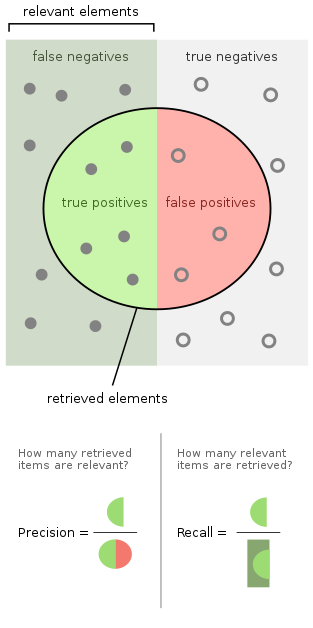 )

### <a name='a9'></a> Wyświetlenie błędów predykcji

In [ ]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors

y_true  y_pred
INCORRECT_MASK/00010_Mask_Mouth_Chin.jpg       0       0
INCORRECT_MASK/00040_Mask_Mouth_Chin.jpg       0       0
INCORRECT_MASK/00042_Mask_Mouth_Chin.jpg       0       0
INCORRECT_MASK/00070_Mask_Mouth_Chin.jpg       0       1
INCORRECT_MASK/00071_Mask_Mouth_Chin.jpg       0       0
...                                          ...     ...
NO_MASK/without_mask_74.jpg                    2       1
NO_MASK/without_mask_76.jpg                    2       2
NO_MASK/without_mask_8.jpg                     2       2
NO_MASK/without_mask_86.jpg                    2       2
NO_MASK/without_mask_88.jpg                    2       2

[327 rows x 2 columns]

In [ ]:
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

y_true  y_pred  is_incorrect
INCORRECT_MASK/00010_Mask_Mouth_Chin.jpg       0       0             0
INCORRECT_MASK/00040_Mask_Mouth_Chin.jpg       0       0             0
INCORRECT_MASK/00042_Mask_Mouth_Chin.jpg       0       0             0
INCORRECT_MASK/00070_Mask_Mouth_Chin.jpg       0       1             1
INCORRECT_MASK/00071_Mask_Mouth_Chin.jpg       0       0             0
...                                          ...     ...           ...
NO_MASK/without_mask_74.jpg                    2       1             1
NO_MASK/without_mask_76.jpg                    2       2             0
NO_MASK/without_mask_8.jpg                     2       2             0
NO_MASK/without_mask_86.jpg                    2       2             0
NO_MASK/without_mask_88.jpg                    2       2             0

[327 rows x 3 columns]

In [ ]:
errors[errors['is_incorrect'] == 1].index

Index(['INCORRECT_MASK/00070_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00112_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00179_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00184_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00252_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00298_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00308_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00459_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00507_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00530_Mask_Nose_Mouth.jpg',
       'INCORRECT_MASK/00552_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00599_Mask_Mouth_Chin.jpg', 'INCORRECT_MASK/132.png',
       'INCORRECT_MASK/142.png', 'INCORRECT_MASK/155.png',
       'INCORRECT_MASK/180.png', 'INCORRECT_MASK/198.png',
       'INCORRECT_MASK/379.png', 'INCORRECT_MASK/446.png',
       'INCORRECT_MASK/478.png', 'INCORRECT_MASK/66.png',
       'MASK/0_0_0 copy 40.jpg', 'MASK/0_0_0 copy 93.jpg',
       'MASK/0_0_1 copy 29.jpg', 'MASK/0_0_16 copy 3.jpg',
       'M

(-0.5, 1023.5, 1023.5, -0.5)

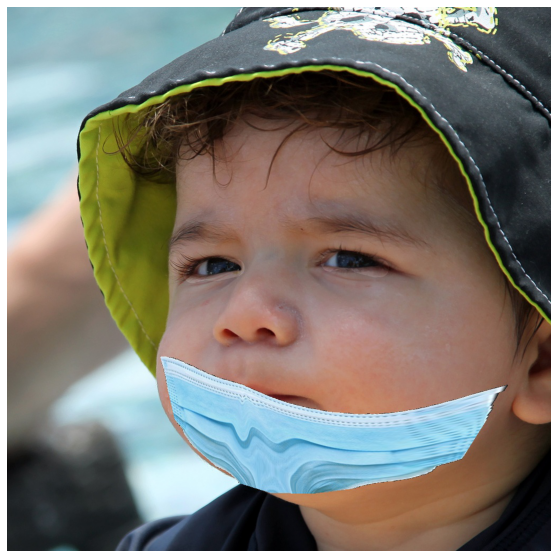

In [ ]:
# Niepoprawnie sklasyfikowane zdjęcia ze zbioru INCORRECT_MASK
img_path = os.path.join(test_incorrect_mask_dir, '00070_Mask_Mouth_Chin.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
errors[errors['is_incorrect'] == 1].index

Index(['INCORRECT_MASK/00070_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00112_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00179_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00184_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00252_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00298_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00308_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00459_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00507_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00530_Mask_Nose_Mouth.jpg',
       'INCORRECT_MASK/00552_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00599_Mask_Mouth_Chin.jpg', 'INCORRECT_MASK/132.png',
       'INCORRECT_MASK/142.png', 'INCORRECT_MASK/155.png',
       'INCORRECT_MASK/180.png', 'INCORRECT_MASK/198.png',
       'INCORRECT_MASK/379.png', 'INCORRECT_MASK/446.png',
       'INCORRECT_MASK/478.png', 'INCORRECT_MASK/66.png',
       'MASK/0_0_0 copy 40.jpg', 'MASK/0_0_0 copy 93.jpg',
       'MASK/0_0_1 copy 29.jpg', 'MASK/0_0_16 copy 3.jpg',
       'M

(-0.5, 124.5, 133.5, -0.5)

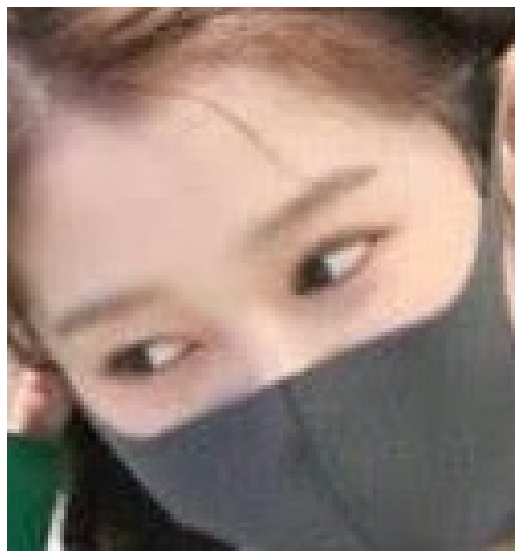

In [ ]:
# Niepoprawnie sklasyfikowane zdjęcia ze zbioru MASK
img_path = os.path.join(test_mask_dir, '0_0_0 copy 40.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
errors[errors['is_incorrect'] == 1].index

Index(['INCORRECT_MASK/00070_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00112_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00179_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00184_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00252_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00298_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00308_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00459_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00507_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00530_Mask_Nose_Mouth.jpg',
       'INCORRECT_MASK/00552_Mask_Mouth_Chin.jpg',
       'INCORRECT_MASK/00599_Mask_Mouth_Chin.jpg', 'INCORRECT_MASK/132.png',
       'INCORRECT_MASK/142.png', 'INCORRECT_MASK/155.png',
       'INCORRECT_MASK/180.png', 'INCORRECT_MASK/198.png',
       'INCORRECT_MASK/379.png', 'INCORRECT_MASK/446.png',
       'INCORRECT_MASK/478.png', 'INCORRECT_MASK/66.png',
       'MASK/0_0_0 copy 40.jpg', 'MASK/0_0_0 copy 93.jpg',
       'MASK/0_0_1 copy 29.jpg', 'MASK/0_0_16 copy 3.jpg',
       'M

(-0.5, 148.5, 147.5, -0.5)

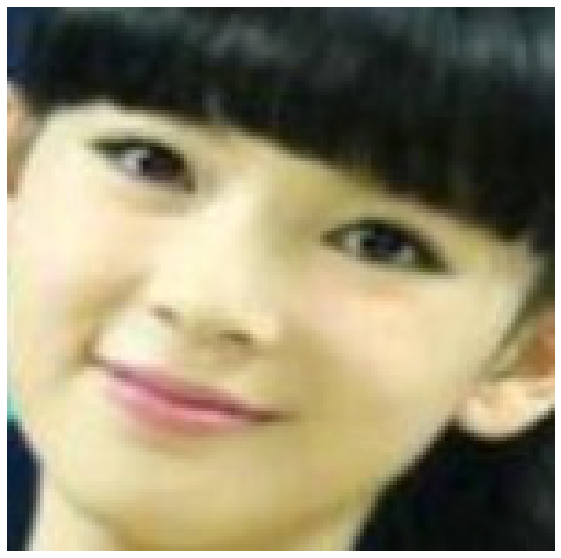

In [ ]:
# Niepoprawnie sklasyfikowane zdjęcia ze zbioru NO_MASK
img_path = os.path.join(test_no_mask_dir, 'without_mask_169.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a9'></a> Zapisywanie modelu

In [ ]:
model.save('path/model_VGG19.h5')